### EDA {exploratory data analysis}

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [15]:
# Create a data-frame for train.csv
df = pd.read_csv("train.csv")
df = df.sample(30000, random_state = 42)
df.shape

(30000, 6)

In [16]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
35471,35471,10592,41171,How can plan a trip for 3 and half days to Goa...,How do I plan a trip to Goa?,1
325510,325510,451766,451767,What are the steps to becoming a professional ...,How do I become a web designer step by step?,0
1618,1618,3222,3223,What makes great movies incredibly engaging?,What are the best movies with a plot twist?,0
277490,277490,396604,344829,Why does some content go viral on the internet?,How do I make a video go viral on WhatsApp?,0
114001,114001,186168,125285,How should I prepare for a manual tester's job...,How can I prepare for manual testing interview...,0


* So we are working on a binary classification problem {0/1}

In [17]:
# info 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 8067 to 213244
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            30000 non-null  int64 
 1   qid1          30000 non-null  int64 
 2   qid2          30000 non-null  int64 
 3   question1     30000 non-null  object
 4   question2     30000 non-null  object
 5   is_duplicate  30000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.6+ MB


In [18]:
# missing values
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

* As the amount of missing data is very less compared to overall data we can simply delete these entries

In [19]:
df = df.dropna()

In [20]:
# duplicate row
df.duplicated().sum()

0

is_duplicate
0    18947
1    11053
Name: count, dtype: int64
is_duplicate
0    63.156667
1    36.843333
Name: count, dtype: float64


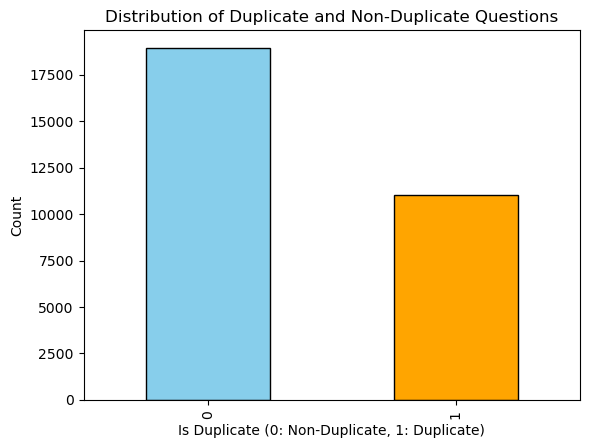

In [21]:
# Distribution of duplicate and non-duplicate questions
print(df["is_duplicate"].value_counts())  # Count of duplicates (1) and non-duplicates (0)
print((df["is_duplicate"].value_counts() / df["is_duplicate"].count()) * 100)  # Percentage distribution

# Plotting the distribution as a bar chart
df["is_duplicate"].value_counts().plot(kind="bar", color=['skyblue', 'orange'], edgecolor='black')

# Adding labels and title for the plot
plt.title('Distribution of Duplicate and Non-Duplicate Questions')
plt.xlabel('Is Duplicate (0: Non-Duplicate, 1: Duplicate)')
plt.ylabel('Count')

# Show the plot
plt.show()

In [22]:
qid = pd.Series(df["qid1"].to_list() + df["qid2"].to_list())
print("Total number of questions", qid.count())
print("Total number of unique questions", np.unique(qid).shape[0])

non_repeated_questions = qid.value_counts() == 1
print("Number of questions asked once", non_repeated_questions.sum())

repeated_questions = qid.value_counts() > 1
print("Number of questions repeated", repeated_questions.sum())

Total number of questions 60000
Total number of unique questions 55464
Number of questions asked once 52092
Number of questions repeated 3372


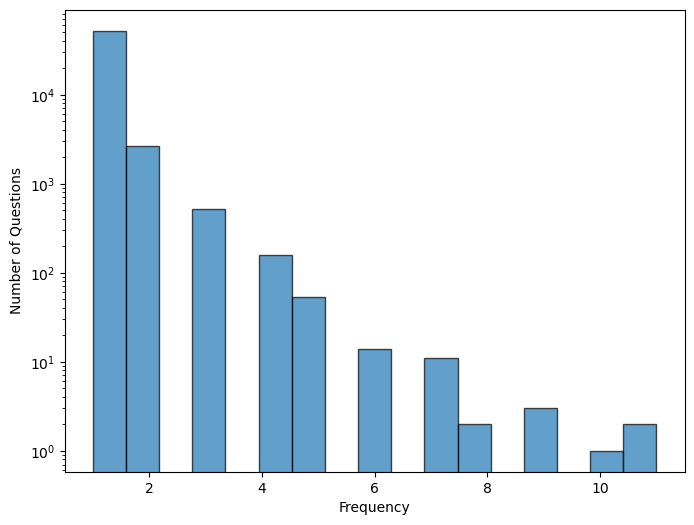

In [23]:
# Plotting histogram of the value counts
plt.figure(figsize=(8, 6))
plt.hist(qid.value_counts(), bins='auto', edgecolor='black', alpha=0.7)
plt.yscale('log')

# Adding labels and title
plt.xlabel('Frequency')
plt.ylabel('Number of Questions')

# Display the plot
plt.show()

### Pre-Processing

In [24]:
import re
import emoji
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
import ast
import string

# Load contractions and slang dictionaries
with open('contractions.txt', 'r') as file:
    content = file.read()
content = '{' + content.strip().rstrip(',') + '}'
contractions_dict = ast.literal_eval(content)

slang_dict = {}
with open('slang.txt', 'r') as file:
    for line in file:
        parts = line.strip().split('=')
        if len(parts) == 2:
            slang_dict[parts[0].strip()] = parts[1].strip()

# Create an instance of the PorterStemmer
ps = PorterStemmer()

def preprocess_text(df):
    # Lower casing and encoding emojis
    df['question1'] = df['question1'].str.lower().apply(encode_emojis)
    df['question2'] = df['question2'].str.lower().apply(encode_emojis)
    
    # Contraction conversion
    df['question1'] = df['question1'].apply(contra_conv)
    df['question2'] = df['question2'].apply(contra_conv)

    # Basic preprocessing (replacing special characters, removing HTML tags)
    df['question1'] = df['question1'].apply(basic_preprocess)
    df['question2'] = df['question2'].apply(basic_preprocess)
    
    # Remove punctuations
    df['question1'] = df['question1'].apply(remove_punc)
    df['question2'] = df['question2'].apply(remove_punc)

    # Chat word treatment (slang replacement)
    df['question1'] = df['question1'].apply(chat_conv)
    df['question2'] = df['question2'].apply(chat_conv)

    # Stemming
    df['question1'] = df['question1'].apply(stem_words)
    df['question2'] = df['question2'].apply(stem_words)

    return df

def remove_punc(text):
    if isinstance(text, str):
        return text.translate(str.maketrans('', '', string.punctuation))
    return text

def encode_emojis(text):
    if isinstance(text, str):
        emojis = re.findall(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF]', text)
        for emoji_ in emojis:
            text = text.replace(emoji_, emoji.demojize(emoji_))
        return text
    return text

def contra_conv(text):
    new_text = []
    if isinstance(text, str):
        for w in text.split():
            if w in contractions_dict:
                new_text.append(contractions_dict[w]) 
            else:
                new_text.append(w)
        return " ".join(new_text)
    return text

def basic_preprocess(q):
    q = q.replace('%', ' percent').replace('$', ' dollar ').replace('₹', ' rupee ').replace('€', ' euro ').replace('@', ' at ')
    q = q.replace(',000,000,000 ', 'b ').replace(',000,000 ', 'm ').replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)

    # Removing HTML tags
    q = BeautifulSoup(q, "html.parser").get_text()
    
    return q

def chat_conv(text):
    new_text = []
    if isinstance(text, str):
        for w in text.split():
            if w.upper() in slang_dict:
                new_text.append(slang_dict[w.upper()]) 
            else:
                new_text.append(w)
        return " ".join(new_text)
    return text

def stem_words(text):
    if isinstance(text, str):
        return " ".join([ps.stem(word) for word in text.split()])
    return text

# Assuming df is your DataFrame
df = preprocess_text(df)

In [27]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
98176,98176,39034,163188,what do guy mean when they ask how can i make ...,is there someth wrong with ask my gf to put he...,0
249365,249365,58000,362992,how is cyclohexan solubl in water,is toluen solubl in water,0
162031,162031,252317,252318,what doe the word yoga mean in sanskrit,what is the most poetic sanskrit word,0
81498,81498,138364,138365,what are some good mff threesom sex posit,can condom help get in good sex posit,0
355919,355919,125083,83136,what happen to udemydownloadercom,what happen to moolacom,0


In [15]:
# Although I have not removed stop-words as they are required
# in the feature engineering step
'''
from nltk.corpus import stopwords

# Get the set of English stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    new_text = []
    if isinstance(text, str):
        for word in text.split():
            # Append only words that are not in the stop words
            if word.lower() not in stop_words:
                new_text.append(word)

        return " ".join(new_text)
    return text

df['question1'] = df['question1'].apply(remove_stopwords)
df['question2'] = df['question2'].apply(remove_stopwords)
'''

* I am deliberately ommiting spelling correction as I am working with a large data set

### Feature Engineering

In [17]:
# Creating our own Basic-features
df['q1_len'] = df['question1'].str.len() # Length of q1
df['q2_len'] = df['question2'].str.len() # Length of q2
df['q1_num_words'] = df['question1'].apply(lambda row : len(row.split(" "))) # number of words in q1
df['q2_num_words'] = df['question2'].apply(lambda row : len(row.split(" "))) # number of words in q2

def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1 & w2)

df['common_words'] = df.apply(common_words, axis = 1)

def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1) +  len(w2)

df['total_words'] = df.apply(total_words, axis = 1)

df['words_shared'] = round(df['common_words'] / df['total_words'], 2)

In [18]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,words_shared
352427,352427,481345,481346,blood type ab blood type would parent,blood type man x blood type live blood chang d...,0,37,83,7,15,2,13,0.15
182395,182395,130481,235470,best bass earphon 1000,best pair inear earphon rs 1000,1,22,31,4,6,3,10,0.30
176770,176770,143558,271885,popular digit market blog india,what best email market campaign youv seen run,0,31,45,5,8,1,13,0.08
73287,73287,51949,72184,better hillari clinton donald trump us presid,hillari clinton better donald trump,1,45,35,7,5,5,12,0.42
342726,342726,357267,470752,marri want travel solo husband protect wont let,forget someon wont marri monetarili unprivileg,0,47,46,8,6,2,14,0.14


Q1 Minimum characters: 0
Q1 Maximum characters: 179
Q1 Average number of characters: 33
Q2 Minimum characters: 0
Q2 Maximum characters: 588
Q2 Average number of characters: 33
Q1 Minimum words: 1
Q1 Maximum words: 31
Q1 Average number of words: 5
Q2 Minimum words: 1
Q2 Maximum words: 103
Q2 Average number of words: 5


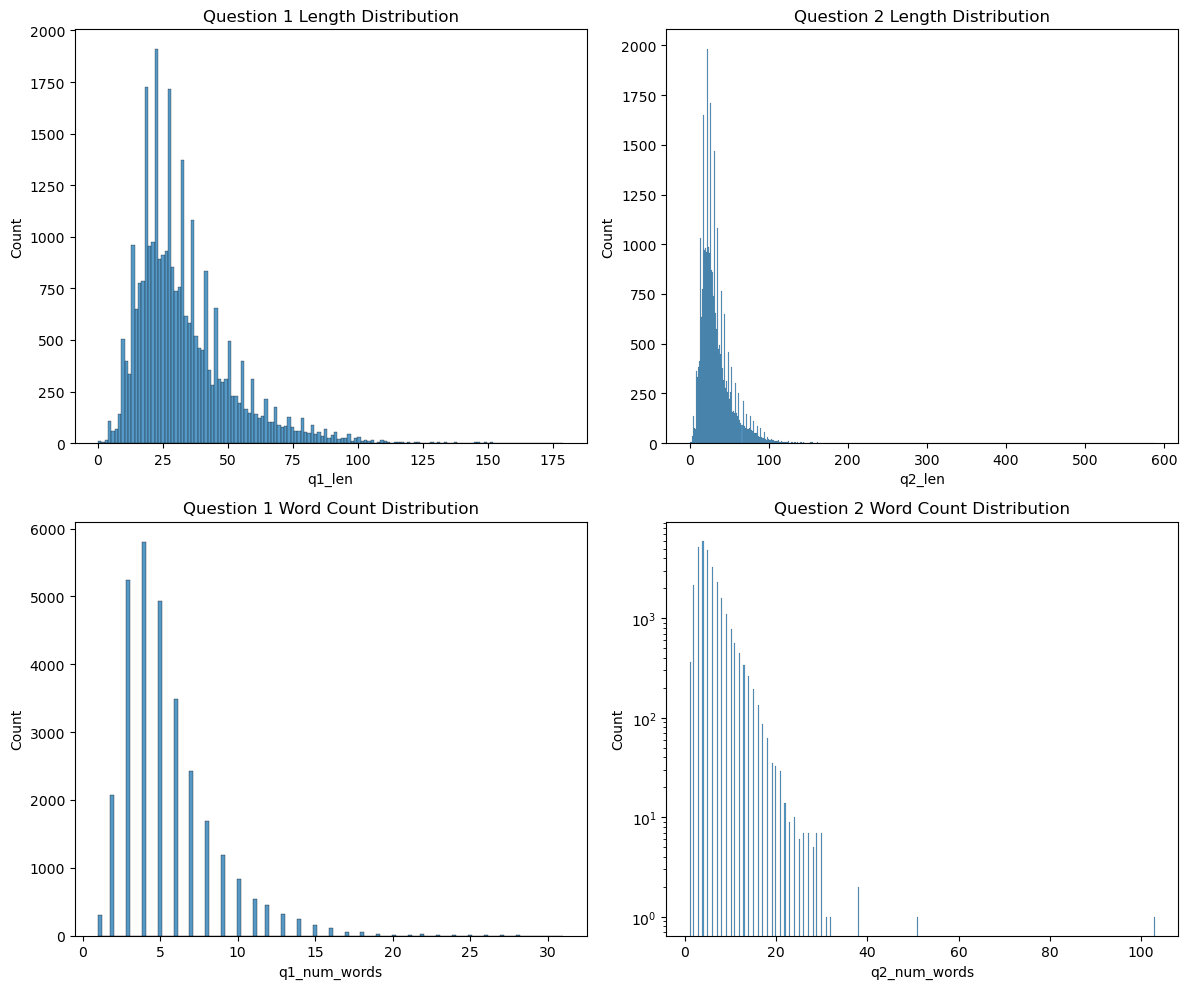

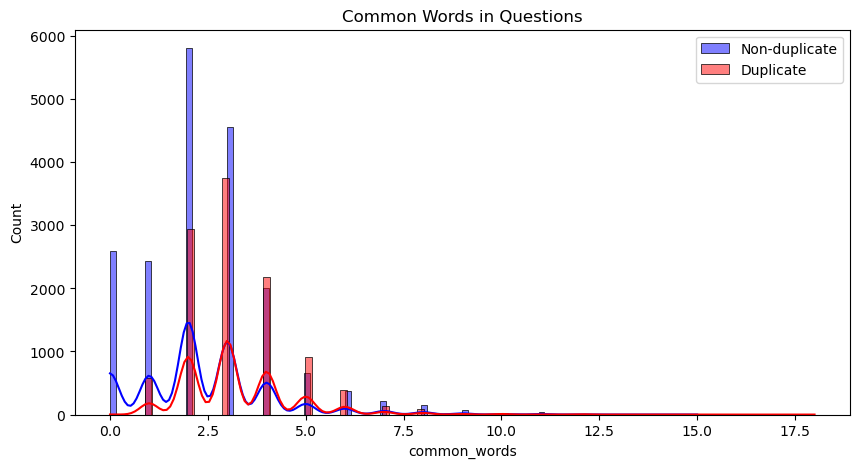

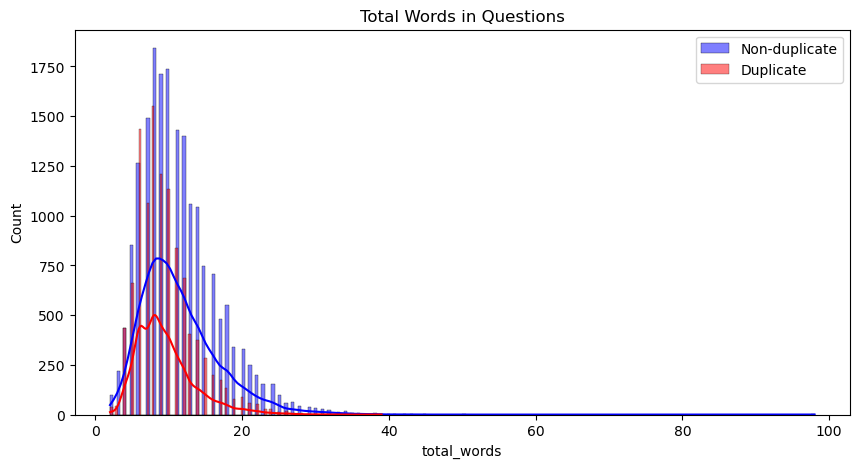

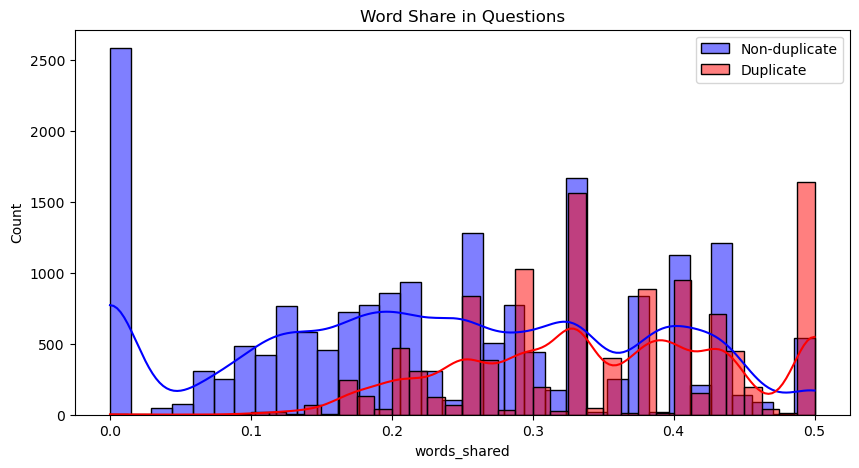

In [19]:
# Plot distributions for q1_len and q2_len
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.histplot(df['q1_len'], ax=axes[0, 0])
axes[0, 0].set_title('Question 1 Length Distribution')
print('Q1 Minimum characters:', df['q1_len'].min())
print('Q1 Maximum characters:', df['q1_len'].max())
print('Q1 Average number of characters:', int(df['q1_len'].mean()))

sns.histplot(df['q2_len'], ax=axes[0, 1])
axes[0, 1].set_title('Question 2 Length Distribution')
print('Q2 Minimum characters:', df['q2_len'].min())
print('Q2 Maximum characters:', df['q2_len'].max())
print('Q2 Average number of characters:', int(df['q2_len'].mean()))

# Plot distributions for q1_num_words and q2_num_words
sns.histplot(df['q1_num_words'], ax=axes[1, 0])
axes[1, 0].set_title('Question 1 Word Count Distribution')
print('Q1 Minimum words:', df['q1_num_words'].min())
print('Q1 Maximum words:', df['q1_num_words'].max())
print('Q1 Average number of words:', int(df['q1_num_words'].mean()))
plt.yscale('log')

sns.histplot(df['q2_num_words'], ax=axes[1, 1])
axes[1, 1].set_title('Question 2 Word Count Distribution')
print('Q2 Minimum words:', df['q2_num_words'].min())
print('Q2 Maximum words:', df['q2_num_words'].max())
print('Q2 Average number of words:', int(df['q2_num_words'].mean()))

plt.yscale('log')
plt.tight_layout()
plt.show()

# Plot word_common for duplicate and non-duplicate
plt.figure(figsize=(10, 5))
sns.histplot(df[df['is_duplicate'] == 0]['common_words'], label='Non-duplicate', color='blue', kde=True)
sns.histplot(df[df['is_duplicate'] == 1]['common_words'], label='Duplicate', color='red', kde=True)
plt.title('Common Words in Questions')
plt.legend()
plt.show()

# Plot word_total for duplicate and non-duplicate
plt.figure(figsize=(10, 5))
sns.histplot(df[df['is_duplicate'] == 0]['total_words'], label='Non-duplicate', color='blue', kde=True)
sns.histplot(df[df['is_duplicate'] == 1]['total_words'], label='Duplicate', color='red', kde=True)
plt.title('Total Words in Questions')
plt.legend()
plt.show()

# Plot word_share for duplicate and non-duplicate
plt.figure(figsize=(10, 5))
sns.histplot(df[df['is_duplicate'] == 0]['words_shared'], label='Non-duplicate', color='blue', kde=True)
sns.histplot(df[df['is_duplicate'] == 1]['words_shared'], label='Duplicate', color='red', kde=True)
plt.title('Word Share in Questions')
plt.legend()
plt.show()

In [28]:
# Advanced Features
from nltk.corpus import stopwords

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [30]:
token_features = df.apply(fetch_token_features, axis=1)

df["cwc_min"]       = list(map(lambda x: x[0], token_features))
df["cwc_max"]       = list(map(lambda x: x[1], token_features))
df["csc_min"]       = list(map(lambda x: x[2], token_features))
df["csc_max"]       = list(map(lambda x: x[3], token_features))
df["ctc_min"]       = list(map(lambda x: x[4], token_features))
df["ctc_max"]       = list(map(lambda x: x[5], token_features))
df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [37]:
import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    if not strs:
        return length_features
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [38]:
length_features = df.apply(fetch_length_features, axis=1)

df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
df['mean_len'] = list(map(lambda x: x[1], length_features))
df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [47]:
# Fuzzy Features
from fuzzywuzzy import fuzz
def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [48]:
fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [49]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
195919,195919,38129,296502,what doe to secur the bless of liberti to ours...,what are some exampl of secur the bless of lib...,0,0.749981,0.428565,0.599988,0.499992,...,0.428568,0,1,4,12.0,0.529412,59,70,62,79
275413,275413,394219,394220,what is the differ between a pinch nerv and a ...,what is the differ between pull muscl and pinc...,1,0.999980,0.999980,0.999980,0.833319,...,0.833326,0,1,2,11.0,0.509434,72,75,96,100
285454,285454,405887,405888,how do you get judi dench signatur hairstyl,how do i get the hairstyl of the guy in thi pi...,0,0.399992,0.399992,0.666644,0.333328,...,0.333331,0,1,4,10.0,0.204545,47,51,60,65
13871,13871,26602,26603,whi is not princ philip the king of england wh...,doe princ charl aim to make camilla queen if h...,0,0.374995,0.333330,0.000000,0.000000,...,0.199999,0,0,3,13.5,0.118644,30,38,44,47
130498,130498,209428,209429,can a boy and a girl remain friend when the bo...,can a boy and a girl remain friend when the gi...,0,0.999988,0.999988,0.777769,0.777769,...,0.749996,1,1,0,20.0,0.483516,93,93,90,97


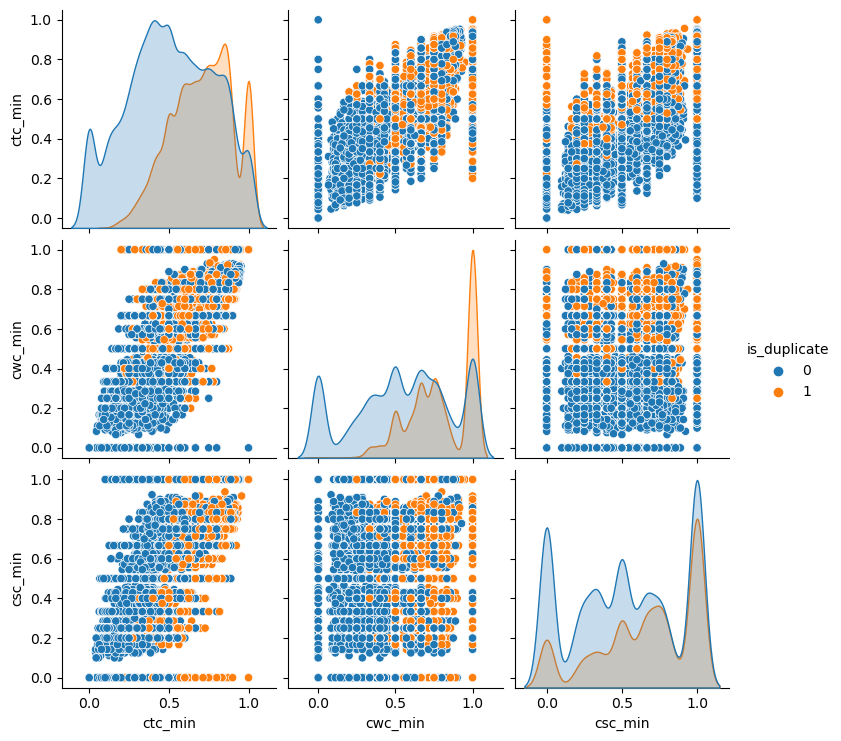

In [53]:
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

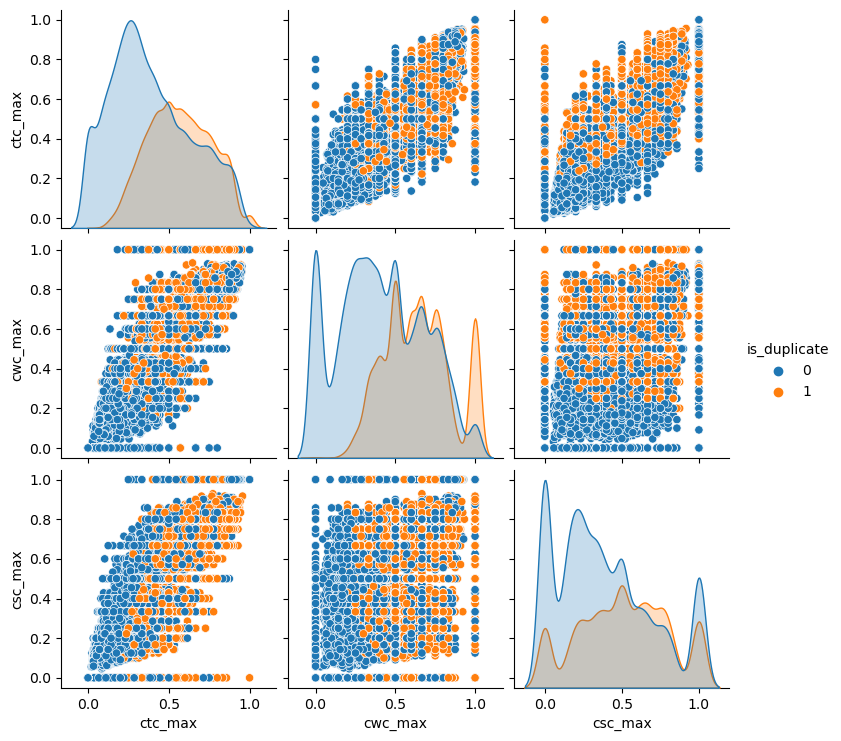

In [56]:
sns.pairplot(df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

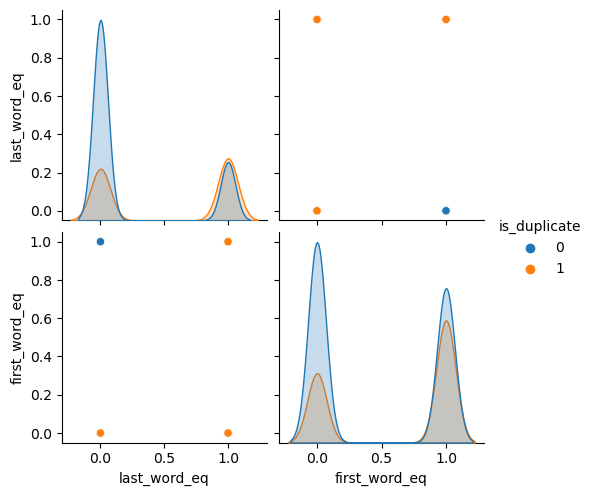

In [57]:
sns.pairplot(df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

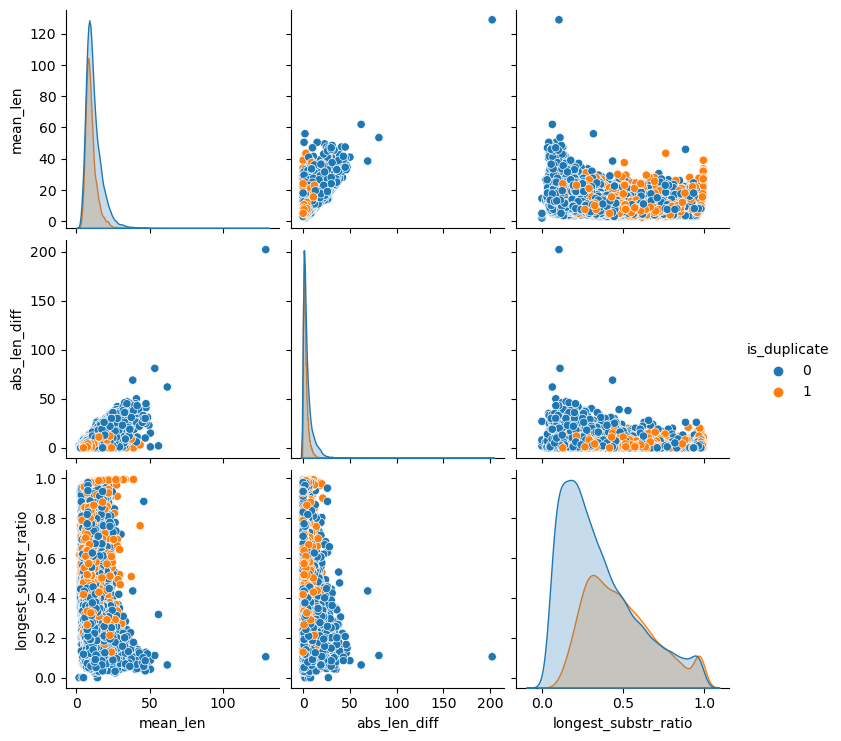

In [58]:
sns.pairplot(df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

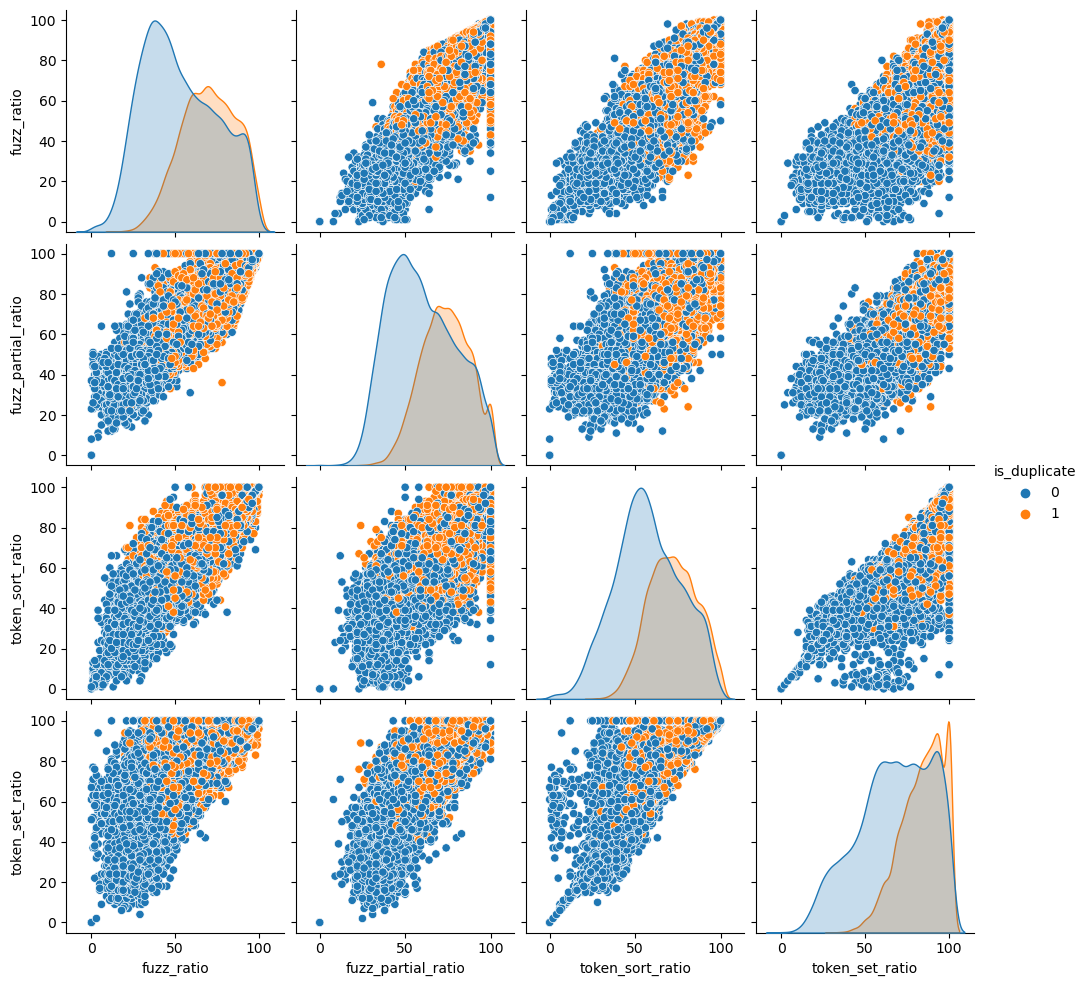

In [59]:
sns.pairplot(df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

In [60]:
# seperate questions
ques_df = df[['question1','question2']]
ques_df.head()

,question1,question2
8067,how do i play pokémon go in korea,how do i play pokémon go in china
368101,what are some of the best side dish for crab cake,what are some good side dish for buffalo chicken
70497,which is more advis and better materi for a cr...,what is the best server setup for buddypress
226567,how do i improv logic program skill,how can i improv my logic skill for program
73186,how close we are to see 3rd world war,how close is a world war iii


In [61]:
# seperate features
features_df = df.drop(columns=['id','qid1','qid2','question1','question2'])
features_df.head()

,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
8067,0,0.749981,0.749981,0.999975,0.999975,0.874989,0.874989,0,1,0,8.0,0.823529,88,88,81,90
368101,0,0.399992,0.399992,0.999975,0.666656,0.666659,0.545450,0,1,2,10.0,0.306122,72,71,72,72
70497,0,0.000000,0.000000,0.499988,0.249997,0.249997,0.124999,0,0,8,12.0,0.111111,36,45,38,24
226567,1,0.999975,0.999975,0.666644,0.399992,0.857131,0.666659,0,1,2,8.0,0.277778,69,71,87,96
73186,1,0.749981,0.599988,0.333322,0.249994,0.571420,0.444440,0,1,2,8.0,0.344828,68,61,71,81


In [62]:
from sklearn.feature_extraction.text import CountVectorizer
# Get sample-space of all words
questions = list(ques_df['question1']) + list(ques_df['question2'])

# set max_features to 3000
cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [63]:
# create df with columns as features and rows as vector then concatinate both df's
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(30000, 6000)

* so a total of 6000 columns, 3000 from q1 and another 3000 from q2
* We will now mix these 6000 with the 7 features we created earlier making a total of 6007 final features

In [64]:
# creating featurised data-frame
features_df = pd.concat([features_df, temp_df], axis=1)
print(features_df.shape)
features_df.head()

(30000, 6016)


,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
8067,0,0.749981,0.749981,0.999975,0.999975,0.874989,0.874989,0,1,0,...,0,0,0,0,0,0,0,0,0,0
368101,0,0.399992,0.399992,0.999975,0.666656,0.666659,0.545450,0,1,2,...,0,0,0,0,0,0,0,0,0,0
70497,0,0.000000,0.000000,0.499988,0.249997,0.249997,0.124999,0,0,8,...,0,0,0,0,0,0,0,0,0,0
226567,1,0.999975,0.999975,0.666644,0.399992,0.857131,0.666659,0,1,2,...,0,0,0,0,0,0,0,0,0,0
73186,1,0.749981,0.599988,0.333322,0.249994,0.571420,0.444440,0,1,2,...,0,0,0,0,0,0,0,0,0,0


### Modelling & Evaluation

In [65]:
# get training and testing data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(features_df.iloc[:, 1:].values, features_df.iloc[:, 0].values, test_size=0.2, random_state = 69)

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7923333333333333

In [67]:
from sklearn.metrics import confusion_matrix
# for random forest model
confusion_matrix(y_test,y_pred)

array([[3351,  463],
       [ 783, 1403]], dtype=int64)